In [97]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import kagglehub


In [98]:
image_height = 224
image_width = 224
num_channels = 3
batch_size = 32
num_classes = 2

In [99]:
data_path=os.path.join("dataset")
image_classes = os.listdir(data_path)
print(image_classes)

['bird', 'drone']


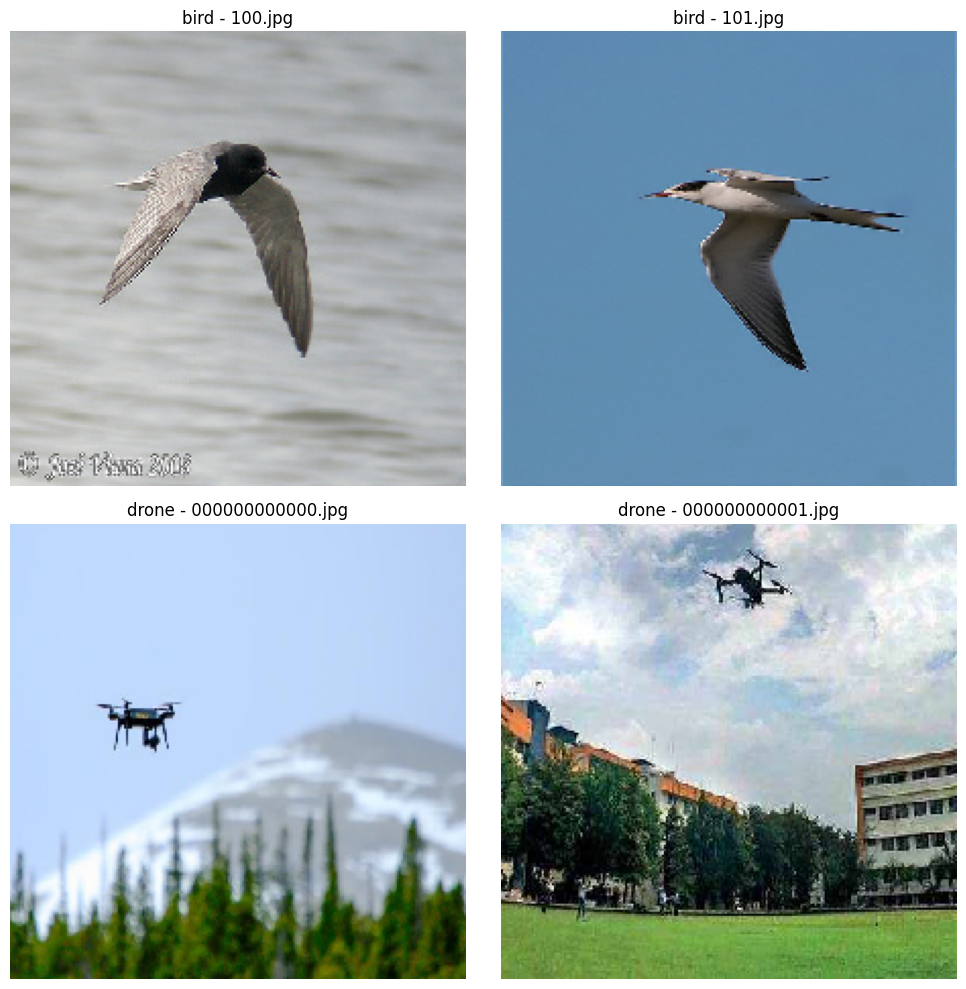

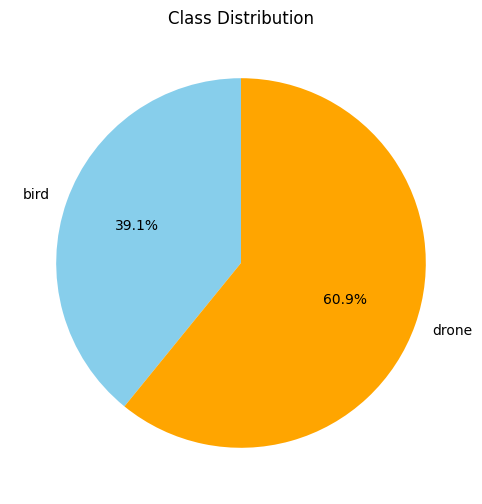

In [100]:
# Display 2 images from both classes
plt.figure(figsize=(10, 10))

for i, category in enumerate(image_classes):
    image_path = os.path.join(data_path, category)
    images_in_folder = os.listdir(image_path)[:2]  # Get first 2 images from each class
    
    for j, image_name in enumerate(images_in_folder):
        img_path = os.path.join(image_path, image_name)
        img = image.load_img(img_path, target_size=(image_height, image_width))
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(2, 2, i * 2 + j + 1)
        plt.imshow(img_array)
        plt.title(f"{category} - {image_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Show a pie chart of class distribution
class_counts = [len(os.listdir(os.path.join(data_path, category))) for category in image_classes]

plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=image_classes, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.show()

In [101]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3  # Split for training and validation
)

In [102]:
train_data = train_datagen.flow_from_directory(
    data_path,  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

Found 2874 images belonging to 2 classes.


In [103]:
val_data = train_datagen.flow_from_directory(
    data_path,  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 1230 images belonging to 2 classes.


In [104]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

In [105]:
base_model.trainable = False

In [106]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [107]:
model.compile(
    optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [108]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [109]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)


c:\Users\ranz1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8656 - loss: 0.2812 - val_accuracy: 0.8244 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9668 - loss: 0.0934 - val_accuracy: 0.8553 - val_loss: 0.4166 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9749 - loss: 0.0711 - val_accuracy: 0.8943 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9808 - loss: 0.0517 - val_accuracy: 0.8821 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9762 - loss: 0.0744 - val_accuracy: 0.8667 - val_loss: 0.4851 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.9745 - loss: 0.0651 - val_accuracy: 0.8976 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9832 - loss: 0.0440 - val_acc

In [110]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8949 - loss: 0.2879
Validation Loss: 0.29342153668403625
Validation Accuracy: 0.8886178731918335


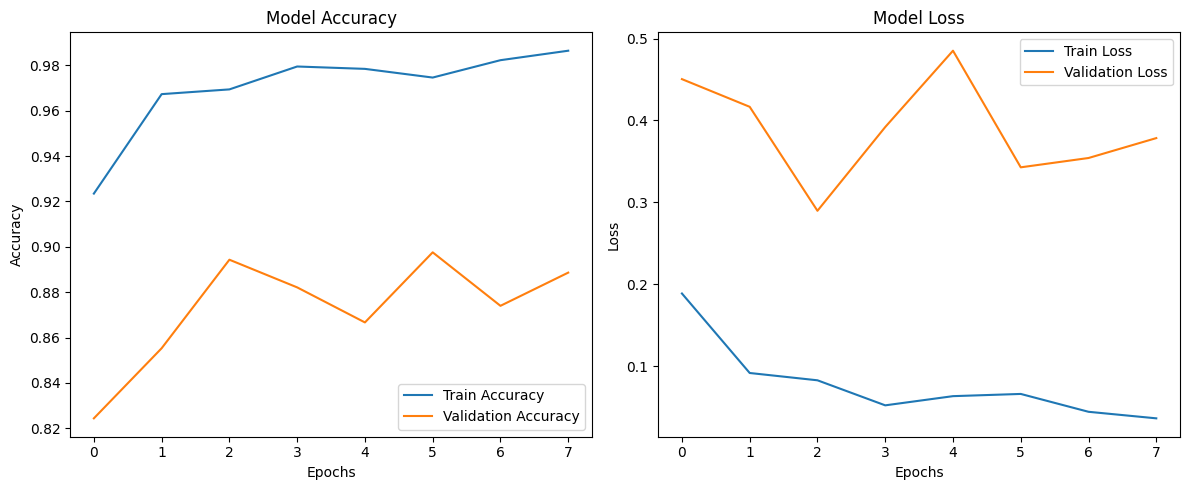

In [111]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
# Fine-Tune the Model (Unfreeze Base Model)
base_model.trainable = True

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

In [113]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 644s 7s/step - accuracy: 0.9520 - loss: 0.1268 - val_accuracy: 0.8805 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 607s 7s/step - accuracy: 0.9866 - loss: 0.0337 - val_accuracy: 0.8846 - val_loss: 0.3953 - learning_rate: 1.0000e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 604s 7s/step - accuracy: 0.9927 - loss: 0.0227 - val_accuracy: 0.8935 - val_loss: 0.4458 - learning_rate: 1.0000e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 606s 7s/step - accuracy: 0.9930 - loss: 0.0213 - val_accuracy: 0.8927 - val_loss: 0.4005 - learning_rate: 1.0000e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - accuracy: 0.9980 - loss: 0.0067 - val_accuracy: 0.9122 - val_loss: 0.3701 - learning_rate: 1.0000e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - accuracy: 0.9981 - loss: 0.0080 - val_accuracy: 0.8780 - val_loss: 0.6449 - learning_rate: 1.0000e-04
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - accuracy: 0.9972 

In [114]:
val_loss_fine, val_accuracy_fine = model.evaluate(val_data)
print(f"Validation Loss (Fine-Tuned): {val_loss_fine}")
print(f"Validation Accuracy (Fine-Tuned): {val_accuracy_fine}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9115 - loss: 0.3300
Validation Loss (Fine-Tuned): 0.28950759768486023
Validation Accuracy (Fine-Tuned): 0.9203252196311951


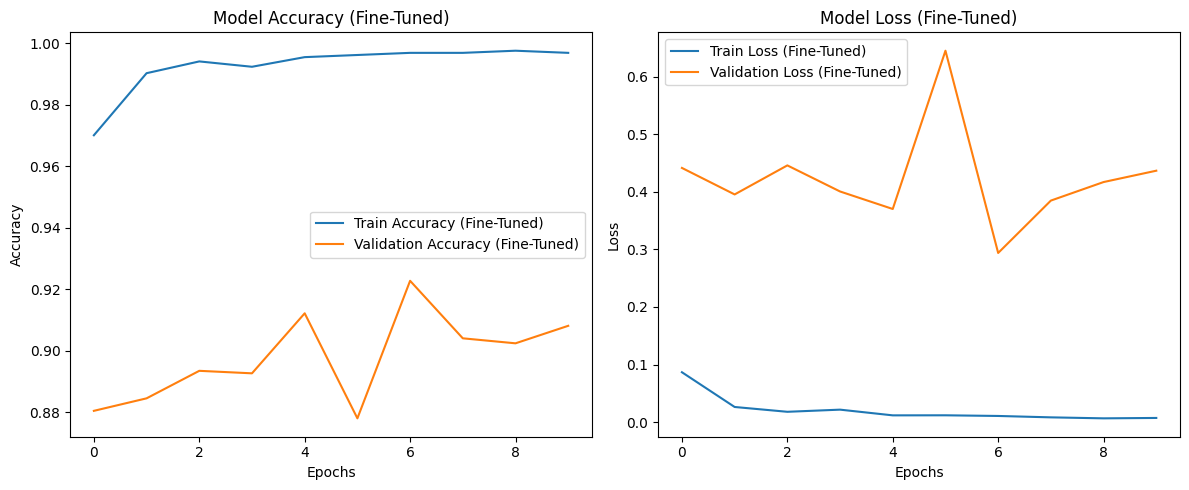

In [115]:
def plot_fine_tuning_history(history_fine):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot 
    plt.subplot(1, 2, 1)
    plt.plot(history_fine.history['accuracy'], label='Train Accuracy (Fine-Tuned)')
    plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Fine-Tuned)')
    plt.title('Model Accuracy (Fine-Tuned)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history_fine.history['loss'], label='Train Loss (Fine-Tuned)')
    plt.plot(history_fine.history['val_loss'], label='Validation Loss (Fine-Tuned)')
    plt.title('Model Loss (Fine-Tuned)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_fine_tuning_history(history_fine)


In [116]:
model.save('BirdVsDrone_model.h5')

39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


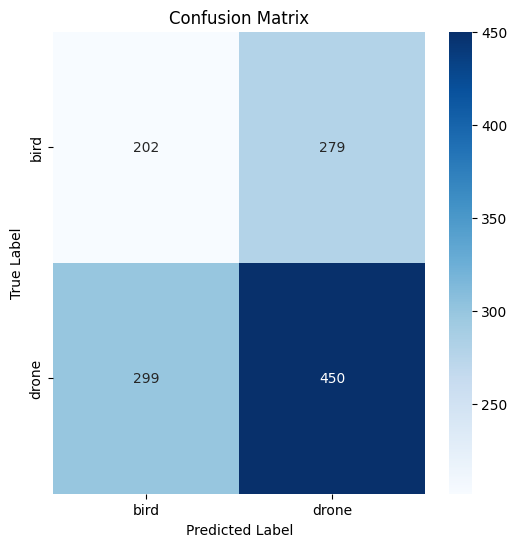

              precision    recall  f1-score   support

        bird       0.40      0.42      0.41       481
       drone       0.62      0.60      0.61       749

    accuracy                           0.53      1230
   macro avg       0.51      0.51      0.51      1230
weighted avg       0.53      0.53      0.53      1230



In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1️⃣ Get the true labels (y_true)
y_true = val_data.classes  # Assuming test_data is your test dataset from flow_from_directory

# 2️⃣ Get the predicted labels (y_pred)
y_pred_prob = model.predict(val_data)  # Get probability outputs
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# 3️⃣ Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4️⃣ Get class labels (Birds = 0, Drones = 1)
class_labels = list(val_data.class_indices.keys())

# 5️⃣ Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 6️⃣ Print a detailed classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

